# aT 농산품 예측 base line (ver. LightGBM)

&nbsp;

## 1. Import module

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
import warnings
from glob import glob
from sklearn.model_selection import train_test_split
import os
import lightgbm as lgb
import datetime

import matplotlib.font_manager as fm
from matplotlib import rc

# 경고 끄기
warnings.filterwarnings(action='ignore')

# # 시드고정
# tf.random.set_seed(1215)
# random.seed(1215)
# np.random.seed(1215)

font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Light.ttc'
font = fm.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# pandas setting
pd.set_option("display.max_columns", None)

# datetime setting
now = datetime.datetime.now().strftime('%m%d%H%M')

print('now:', now)
print('Lightgbm version:', lgb.__version__)

now: 09271553
Lightgbm version: 3.3.2


&nbsp;

## 2. Data loader, parameter setting

In [2]:
data_list = glob('./data//train/*.csv')
epoch = 1000 # default: 1000
batch = 15 # default: 15

# tr_del_list = ['단가(원)', '거래량', '거래대금(원)', '경매건수', '도매시장코드', '도매법인코드', '산지코드 '] # train 에서 사용하지 않는 열
# ts_del_list = ['단가(원)', '거래량', '거래대금(원)', '경매건수', '도매시장코드', '도매법인코드', '산지코드 ', '해당일자_전체평균가격(원)'] # test 에서 사용하지 않는 열

'''
tr_del_list = ['거래량', '거래대금(원)', '경매건수', '해당일자_전체거래물량(kg)', '하위가격 거래물량(kg)', '상위가격 거래물량(kg)',
                '수출중량(kg)', '수출금액(달러)', '수입중량(kg)', '수입금액(달러)'] # train 에서 사용하지 않는 열
ts_del_list = ['거래량', '거래대금(원)', '경매건수', '해당일자_전체거래물량(kg)', '하위가격 거래물량(kg)', '상위가격 거래물량(kg)',
                '수출중량(kg)', '수출금액(달러)', '수입중량(kg)', '수입금액(달러)'] # test 에서 사용하지 않는 열
'''

tr_del_list = ['거래량', '거래대금(원)'] # train 에서 사용하지 않는 열
ts_del_list = ['거래량', '거래대금(원)'] # test 에서 사용하지 않는 열

check_col = ['일자구분_중순', '일자구분_초순', '일자구분_하순'] # 열 개수 맞추기

# check_col = ['일자구분_중순', '일자구분_초순', '일자구분_하순', '월구분_10월', '월구분_11월', '월구분_12월', '월구분_1월', '월구분_2월', '월구분_3월', 
#              '월구분_4월','월구분_5월', '월구분_6월', '월구분_7월', '월구분_8월', '월구분_9월'] # 열 개수 맞추기


# parameter setting
'''
params = {'learning_rate': 0.05,
'max_depth': 64,
'max_bin': 500,
'boosting': 'gbdt',
'objective': 'regression',
'metric': 'rmse',
'is_training_metric': True,
'num_leaves': 288,
'feature_fraction': 0.8,
'bagging_fraction': 0.8,
'bagging_freq': 5,
'seed': 1215
}
'''
params = {'learning_rate': 0.01,
'boosting': 'gbdt',
'objective': 'rmse',
'metric': 'rmse',
'is_training_metric': True,
'feature_fraction': 0.8,
'bagging_fraction': 0.8,
'lambda_l1': 1,
'lambda_l2': 1,
'seed': 1215
}


## Train 과정

In [35]:
df_ = pd.read_csv(data_list[1])
df_.describe()

,datadate,단가(원),거래량,거래대금(원),경매건수,도매시장코드,도매법인코드,산지코드,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),하위가격 평균가(원),상위가격 평균가(원),하위가격 거래물량(kg),상위가격 거래물량(kg),일자별_도매가격_최대(원),일자별_도매가격_평균(원),일자별_도매가격_최소(원),일자별_소매가격_최대(원),일자별_소매가격_평균(원),일자별_소매가격_최소(원),수출중량(kg),수출금액(달러),수입중량(kg),수입금액(달러),무역수지(달러),주산지_0_초기온도(℃),주산지_0_최대온도(℃),주산지_0_최저온도(℃),주산지_0_평균온도(℃),주산지_0_강수량(ml),주산지_1_초기온도(℃),주산지_1_최대온도(℃),주산지_1_최저온도(℃),주산지_1_평균온도(℃),주산지_1_강수량(ml),주산지_1_습도(%),주산지_2_초기온도(℃),주산지_2_최대온도(℃),주산지_2_최저온도(℃),주산지_2_평균온도(℃),주산지_2_강수량(ml),일자구분_중순,일자구분_초순,일자구분_하순,월구분_10월,월구분_11월,월구분_12월,월구분_1월,월구분_2월,월구분_3월,월구분_4월,월구분_5월,월구분_6월,월구분_7월,월구분_8월,월구분_9월
count,1.461000e+03,1241.000000,1241.000000,1.241000e+03,1241.000000,1241.000000,1.241000e+03,1241.000000,1241.000000,1.241000e+03,1240.000000,1239.000000,1.240000e+03,1.239000e+03,948.000000,948.000000,948.000000,941.000000,941.000000,941.000000,1.461000e+03,1.461000e+03,1.461000e+03,1461.000000,1.461000e+03,1454.000000,1454.000000,1454.000000,1454.000000,1454.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000
mean,2.014568e+07,996.881225,8563.552780,4.941807e+06,5.643030,265702.500403,2.657025e+07,543.117647,552.571089,1.529179e+06,442.113162,664.392592,7.516443e+05,7.793967e+05,16107.805907,14715.217224,13567.099156,2857.917109,2165.503185,1486.950053,3.745361e+05,2.235891e+05,3.038715e+05,72055.682409,1.515334e+05,9.722008,18.058666,6.549381,12.110110,3.630261,7.809110,17.187923,4.912629,10.433885,3.596894,74.078261,6.786606,17.393095,3.517055,10.001414,3.152080,0.328542,0.328542,0.342916,0.084873,0.082136,0.084873,0.084873,0.077344,0.084873,0.082136,0.084873,0.082136,0.084873,0.084873,0.082136
std,1.119215e+04,1887.434669,25301.969722,2.064993e+07,8.798408,82871.145727,8.287114e+06,216.943290,288.760968,5.476058e+05,225.706295,478.796780,3.476596e+05,2.639957e+05,6508.613596,5983.843549,5719.861091,814.323840,674.417443,568.471960,4.796193e+05,2.755610e+05,4.821793e+05,104522.708669,2.633318e+05,10.047282,10.048887,10.694390,10.052706,11.575898,10.267792,10.453427,10.919632,10.406861,9.483178,13.895963,11.005067,11.148382,11.659060,11.083977,10.262602,0.469844,0.469844,0.474846,0.278789,0.274665,0.278789,0.278789,0.267228,0.278789,0.274665,0.278789,0.274665,0.278789,0.278789,0.274665
min,2.013010e+07,40.040000,1.000000,4.995000e+03,1.000000,110001.000000,1.100010e+07,56.000000,209.029466,2.200000e+01,132.383560,254.543182,1.600000e+01,6.000000e+00,8000.000000,7000.000000,6000.000000,2000.000000,1246.129032,600.000000,7.258000e+03,6.489000e+03,0.000000e+00,0.000000,-3.006870e+05,-16.700000,-9.500000,-20.600000,-13.500000,0.000000,-18.800000,-10.300000,-21.900000,-16.800000,0.000000,32.500000,-23.000000,-12.400000,-25.200000,-19.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.014010e+07,320.320000,600.000000,3.213210e+05,2.000000,220001.000000,2.200011e+07,350.000000,362.354234,1.220496e+06,290.204574,437.583459,5.390132e+05,6.194750e+05,11000.000000,9400.000000,9000.000000,2000.000000,1604.418605,1000.000000,2.862000e+04,4.027400e+04,3.337600e+04,9141.000000,8.370000e+03,1.100000,9.925000,-2.375000,4.200000,0.000000,-0.600000,8.000000,-3.800000,2.000000,0.000000,63.900000,-2.200000,7.800000,-5.500000,1.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.015010e+07,509.490000,4000.000000,1.601600e+06,4.000000,250003.000000,2.500030e+07,573.000000,476.692270,1.461428e+06,379.624799,574.501035,6.818435e+05,7.640750e+05,14000.000000,12905.555556,12000.000000,2660.000000,1966.071429,1320.000000,1.836220e+05,1.073430e+05,1.191200e+05,33034.000000,3.814300e+04,9.7000

In [3]:
'''
cat_features = ['month', 'dayoftheweek', '도매시장코드', '도매법인코드', '일자구분_중순', '일자구분_초순', '일자구분_하순',
              '산지코드 ', '수출중량(kg)', '수출금액(달러)', '수입중량(kg)', '수입금액(달러)', '일자별_도매가격_최대(원)', '일자별_도매가격_최소(원)', '일자별_소매가격_최대(원)', '일자별_소매가격_최소(원)', '무역수지(달러)']
'''
cat_features = ['month', 'dayoftheweek', '도매시장코드', '도매법인코드', '일자구분_중순', '일자구분_초순', '일자구분_하순',
              '산지코드 ']

cat_del = ['월구분_10월', '월구분_11월', '월구분_12월', '월구분_1월', '월구분_2월', '월구분_3월', 
             '월구분_4월','월구분_5월', '월구분_6월', '월구분_7월', '월구분_8월', '월구분_9월']



In [3]:
i_ = pd.read_csv(data_list[0])
i_['datetime'] = pd.to_datetime(i_['datadate'], format='%Y%m%d')
i_.drop('datadate', axis=1, inplace=True)

In [4]:
i_.set_index('datetime', drop=True, inplace=True)

In [85]:
i_['dayoftheweek'] = i_['datetime'].dt.day_of_week
# df['month'] = df['datetime'].dt.month
# i_

In [47]:
df.describe()

,단가(원),경매건수,해당일자_전체평균가격(원),해당일자_전체거래물량(kg),하위가격 평균가(원),상위가격 평균가(원),하위가격 거래물량(kg),상위가격 거래물량(kg),일자별_도매가격_최대(원),일자별_도매가격_평균(원),일자별_도매가격_최소(원),일자별_소매가격_최대(원),일자별_소매가격_평균(원),일자별_소매가격_최소(원),수출중량(kg),수출금액(달러),수입중량(kg),수입금액(달러),무역수지(달러),주산지_0_초기온도(℃),주산지_0_최대온도(℃),주산지_0_최저온도(℃),주산지_0_평균온도(℃),주산지_0_강수량(ml),주산지_0_습도(%),주산지_1_초기온도(℃),주산지_1_최대온도(℃),주산지_1_최저온도(℃),주산지_1_평균온도(℃),주산지_1_강수량(ml),주산지_1_습도(%),주산지_2_초기온도(℃),주산지_2_최대온도(℃),주산지_2_최저온도(℃),주산지_2_평균온도(℃),주산지_2_강수량(ml),주산지_2_습도(%)
count,1237.000000,1237.000000,1237.000000,1.237000e+03,1236.000000,1236.000000,1.236000e+03,1.236000e+03,948.000000,948.000000,948.000000,941.000000,941.000000,941.000000,1430.000000,1430.000000,1430.000000,1430.000000,1430.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,0.0,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000
mean,1756.764131,13.260307,1707.043993,8.163601e+05,1406.135264,1991.223879,4.173441e+05,3.996765e+05,18196.940928,16516.387131,15075.685654,24513.390011,20286.239819,16426.078640,22326.484615,40049.441259,8734.534965,36836.062238,3213.379021,7.809110,17.187923,4.912629,10.433885,3.596894,74.078261,11.511501,17.841725,9.090393,13.098668,4.223422,NaN,12.900276,20.083621,10.259088,14.782101,4.630961,65.226538
std,909.365362,15.184150,704.992861,1.140560e+06,634.032631,759.371960,5.931901e+05,5.525162e+05,4480.006167,4040.885967,3941.997234,4223.831135,3762.069778,3755.372383,27911.672169,48578.600195,13477.641940,56526.656727,82621.006599,10.267792,10.453427,10.919632,10.406861,9.483178,13.895963,10.208966,10.598146,10.509207,10.292375,11.753161,NaN,8.961194,9.030348,9.386650,8.944421,14.689707,17.559369
min,80.080000,1.000000,631.583422,1.076000e+03,378.910999,917.551611,8.100000e+02,1.360000e+02,7000.000000,6560.000000,6000.000000,18000.000000,13120.833333,8900.000000,0.000000,0.000000,0.000000,0.000000,-244056.000000,-18.800000,-10.300000,-21.900000,-16.800000,0.000000,32.500000,-15.500000,-10.900000,-17.900000,-14.500000,0.000000,NaN,-9.400000,-2.500000,-11.700000,-7.200000,0.000000,17.300000
25%,1021.020000,5.000000,1045.059583,6.298000e+04,835.694138,1287.953210,3.001550e+04,3.349300e+04,16000.000000,14600.000000,13000.000000,20600.000000,17386.666667,13500.000000,871.000000,2126.000000,0.000000,0.000000,-52055.000000,-0.600000,8.000000,-3.800000,2.000000,0.000000,63.900000,3.100000,8.900000,1.000000,4.900000,0.000000,NaN,5.350000,12.600000,2.200000,7.250000,0.000000,51.700000
50%,1611.610000,9.000000,1593.575932,1.293920e+05,1291.163951,1897.894458,6.668950e+04,6.398450e+04,18400.000000,16800.000000,15000.000000,24000.000000,19386.956522,15500.000000,8386.000000,21991.000000,0.000000,0.000000,7383.000000,8.000000,18.800000,4.700000,11.100000,0.000000,75.400000,11.800000,19.000000,9.350000,13.700000,0.000000,NaN,13.100000,21.000000,10.100000,15.200000,0.000000,66.300000
75%,2322.320000,15.000000,2289.614829,1.368095e+06,1902.955752,2587.984117,6.740640e+05,7.185800e+05,20000.000000,18800.000000,18000.000000,28000.000000,23406.666667,19000.000000,51029.000000,77845.000000,16069.000000,62552.000000,40840.000000,16.700000,26.000000,14.300000,19.500000,2.400000,84.900000,20.400000,27.000000,18.275000,22.200000,2.400000,NaN,20.500000,27.700000,18.400000,22.300000,1.950000,78.500000
max,6926.920000,147.000000,3717.338490,5.337675e+06,3414.753367,4624.472794,2.595141e+06,2.742534e+06,33000.000000,27840.000000,26000.000000,42800.000000,29538.461538,27000.000000,129595.000000,221795.000000,48989.000000,256698.000000,221795.000000,27.700000,39.400000,25.300000,29.900000,95.000000,100.000000,32.300000,38.700000,28.900000,33.000000,104.400000,NaN,30.700000,37.300000,28.400000,31.600000,170.500000,99.400000


In [4]:
# lgbm baseline (d-day)

for i in tqdm(data_list):
    df_number = i.split("_")[-1].split(".")[0]
    df = pd.read_csv(i)

    for j in df.columns: 
        df[j] = df[j].replace({' ': np.nan})

    # 사용할 열 선택 및 index 설정
    # df.drop(tr_del_list, axis=1, inplace=True)

    df['datetime'] = pd.to_datetime(df['datadate'], format='%Y%m%d')
    df.drop('datadate', axis=1, inplace=True)

    # df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['dayoftheweek'] = df['datetime'].dt.day_of_week

    df.drop(cat_del, axis=1, inplace=True)

    df.set_index('datetime', drop=True, inplace=True)

    # df.set_index('datadate', drop=True, inplace=True)

    # nan 처리
    # df = df.fillna(0)

    # to categorical type
    # for NUM_i in range(1,3):
    #     df[df.columns[NUM_i]] = df[df.columns[NUM_i]].astype('category')

    for i_ca in enumerate(cat_features) :
        ca = i_ca[1]
        df[ca] = df[ca].astype("category")

    # 변수와 타겟 분리
    # x, y = df[[i for i in df.columns if i != '해당일자_전체평균가격(원)']], df['해당일자_전체평균가격(원)']
    x, y = df, df['해당일자_전체평균가격(원)']

    # type 변경
    x = x.astype({'주산지_0_습도(%)':'float64', '주산지_1_습도(%)':'float64','주산지_2_습도(%)':'float64'})

    # 2주 입력을 통한 이후 4주 예측을 위해 y의 첫 14일을 제외
    y = y[14:]

    # y의 길이와 같은 길이로 설정
    xdata = x[:len(y)]
    ydata = y

    # train, validation 분리 (8 : 2)
    x_train, x_val, y_train, y_val = train_test_split(xdata, ydata, test_size=0.2, shuffle=True, random_state=1215)
    train_ds = lgb.Dataset(x_train, label = y_train)
    test_ds = lgb.Dataset(x_val, label = y_val)


    # lgbm 모델 훈련
    
    lgbm_model = lgb.train(params=params, train_set=train_ds, valid_sets=test_ds, num_boost_round=5000, verbose_eval=500, early_stopping_rounds=250, categorical_feature='auto') # categorical_feature = [''], 'auto'


    if os.path.exists(f'./model{now}') == False:
        os.mkdir(f'./model{now}')

    # 모델 저장
    lgbm_model.save_model(f'./model{now}/lgbm-{df_number}-{epoch}-{batch}.txt')

  0%|          | 0/37 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4876
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1467.022398
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 1044.71


  3%|▎         | 1/37 [00:01<01:05,  1.83s/it]

Early stopping, best iteration is:
[282]	valid_0's rmse: 1019.33
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7263
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 464.430646
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 417.315
[1000]	valid_0's rmse: 414.335
[1500]	valid_0's rmse: 413.548
[2000]	valid_0's rmse: 413.206
[2500]	valid_0's rmse: 413.068
[3000]	valid_0's rmse: 412.9


  5%|▌         | 2/37 [00:16<05:24,  9.28s/it]

Early stopping, best iteration is:
[3114]	valid_0's rmse: 412.836
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6791
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1386.915729
Training until validation scores don't improve for 250 rounds


  8%|▊         | 3/37 [00:18<03:26,  6.08s/it]

[500]	valid_0's rmse: 305.09
Early stopping, best iteration is:
[254]	valid_0's rmse: 300.061
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7402
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2949.958536
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 855.755


 11%|█         | 4/37 [00:21<02:43,  4.96s/it]

Early stopping, best iteration is:
[496]	valid_0's rmse: 855.472
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6800
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 3226.919744
Training until validation scores don't improve for 250 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

 14%|█▎        | 5/37 [00:27<02:51,  5.35s/it]

Early stopping, best iteration is:
[1144]	valid_0's rmse: 630.244
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6864
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 3199.975996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 250 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

 16%|█▌        | 6/37 [00:30<02:14,  4.35s/it]

Early stopping, best iteration is:
[344]	valid_0's rmse: 731.336
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6851
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 42
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 4628.413912
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 1662.81


 19%|█▉        | 7/37 [00:34<02:07,  4.24s/it]

Early stopping, best iteration is:
[654]	valid_0's rmse: 1657.04
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6703
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1929.896436
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 591.197


 22%|██▏       | 8/37 [00:37<01:52,  3.88s/it]

Early stopping, best iteration is:
[416]	valid_0's rmse: 588.958
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6820
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1458.432179
Training until validation scores don't improve for 250 rounds


 24%|██▍       | 9/37 [00:39<01:34,  3.36s/it]

[500]	valid_0's rmse: 348.543
Early stopping, best iteration is:
[288]	valid_0's rmse: 347.15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6405
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 3568.522684
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 3460.76
[1000]	valid_0's rmse: 3433.34


 27%|██▋       | 10/37 [00:44<01:39,  3.70s/it]

Early stopping, best iteration is:
[812]	valid_0's rmse: 3416.78
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6619
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7561.379509
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 3873.44


 30%|██▉       | 11/37 [00:47<01:36,  3.70s/it]

Early stopping, best iteration is:
[635]	valid_0's rmse: 3863.55
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6655
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 41
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 3192.425419
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 772.398


 32%|███▏      | 12/37 [00:50<01:24,  3.39s/it]

Early stopping, best iteration is:
[338]	valid_0's rmse: 765.767
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7050
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 3793.232572
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 774.753


 35%|███▌      | 13/37 [00:54<01:26,  3.61s/it]

Early stopping, best iteration is:
[660]	valid_0's rmse: 771.98
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7300
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 519.847609
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 155.783


 38%|███▊      | 14/37 [00:58<01:24,  3.67s/it]

Early stopping, best iteration is:
[682]	valid_0's rmse: 155.58
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7244
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1286.299146
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 401.788
[1000]	valid_0's rmse: 398.61
[1500]	valid_0's rmse: 397.134
[2000]	valid_0's rmse: 395.749
[2500]	valid_0's rmse: 395.045


 41%|████      | 15/37 [01:11<02:22,  6.46s/it]

Early stopping, best iteration is:
[2639]	valid_0's rmse: 394.936
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6530
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 41
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2346.144819
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 1250.33


 43%|████▎     | 16/37 [01:13<01:49,  5.21s/it]

Early stopping, best iteration is:
[388]	valid_0's rmse: 1246.76
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7388
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1099.045562
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 243.544
[1000]	valid_0's rmse: 237.246
[1500]	valid_0's rmse: 235.732


 46%|████▌     | 17/37 [01:20<01:57,  5.86s/it]

Early stopping, best iteration is:
[1419]	valid_0's rmse: 235.325
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6881
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1785.996403
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 348.921
[1000]	valid_0's rmse: 347.883


 49%|████▊     | 18/37 [01:26<01:48,  5.72s/it]

Early stopping, best iteration is:
[1012]	valid_0's rmse: 347.813
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7326
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 640.055162
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 153.908


 51%|█████▏    | 19/37 [01:30<01:35,  5.30s/it]

Early stopping, best iteration is:
[723]	valid_0's rmse: 153.253
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7545
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 563.678313
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 205.027
[1000]	valid_0's rmse: 200.385
[1500]	valid_0's rmse: 199.563
[2000]	valid_0's rmse: 199.011
[2500]	valid_0's rmse: 198.845


 54%|█████▍    | 20/37 [01:41<02:00,  7.07s/it]

Early stopping, best iteration is:
[2429]	valid_0's rmse: 198.785
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6895
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2093.976712
Training until validation scores don't improve for 250 rounds


 57%|█████▋    | 21/37 [01:44<01:32,  5.76s/it]

[500]	valid_0's rmse: 649.207
Early stopping, best iteration is:
[284]	valid_0's rmse: 643.757
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6852
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1339.650442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 250 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	valid_0's rmse: 232.474
[1000]	valid_0's rmse: 229.139
[1500]	valid_0's rmse: 227.993
[2000]	valid_0's rm

 59%|█████▉    | 22/37 [01:56<01:52,  7.51s/it]

Early stopping, best iteration is:
[2419]	valid_0's rmse: 226.062
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7088
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 42
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 830.543962
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 295.245


 62%|██████▏   | 23/37 [02:00<01:32,  6.58s/it]

[1000]	valid_0's rmse: 293.266
Early stopping, best iteration is:
[793]	valid_0's rmse: 292.959
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6547
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2938.064666
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 928.988


 65%|██████▍   | 24/37 [02:03<01:12,  5.55s/it]

Early stopping, best iteration is:
[371]	valid_0's rmse: 923.325
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6764
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 45
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1765.183567
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 442.676
[1000]	valid_0's rmse: 434.413
[1500]	valid_0's rmse: 433.525


 68%|██████▊   | 25/37 [02:11<01:14,  6.17s/it]

Early stopping, best iteration is:
[1560]	valid_0's rmse: 433.293
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7271
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 42
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 3006.242078
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 943.073
[1000]	valid_0's rmse: 934.242


 70%|███████   | 26/37 [02:17<01:07,  6.13s/it]

Early stopping, best iteration is:
[1039]	valid_0's rmse: 933.608
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6472
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 41
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6678.461895
Training until validation scores don't improve for 250 rounds


 73%|███████▎  | 27/37 [02:19<00:49,  4.96s/it]

[500]	valid_0's rmse: 2237.52
Early stopping, best iteration is:
[267]	valid_0's rmse: 2221.9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6715
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2602.780041
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 521.905
[1000]	valid_0's rmse: 519.199


 76%|███████▌  | 28/37 [02:26<00:48,  5.43s/it]

[1500]	valid_0's rmse: 517.093
Early stopping, best iteration is:
[1282]	valid_0's rmse: 516.621
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6915
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 908.217312
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 192.977


 78%|███████▊  | 29/37 [02:29<00:37,  4.72s/it]

Early stopping, best iteration is:
[414]	valid_0's rmse: 191.77
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6834
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1900.982629
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 569.646
[1000]	valid_0's rmse: 561.263


 81%|████████  | 30/37 [02:34<00:33,  4.76s/it]

Early stopping, best iteration is:
[844]	valid_0's rmse: 560.863
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6797
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 40
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2155.262046
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 929.109
[1000]	valid_0's rmse: 925.581


 84%|████████▍ | 31/37 [02:39<00:30,  5.05s/it]

Early stopping, best iteration is:
[1097]	valid_0's rmse: 924.912
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7334
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2267.596224
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 1036.44


 86%|████████▋ | 32/37 [02:42<00:22,  4.42s/it]

Early stopping, best iteration is:
[368]	valid_0's rmse: 1028.21
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7086
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 45
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1494.275143
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 392.169


 89%|████████▉ | 33/37 [02:45<00:16,  4.01s/it]

Early stopping, best iteration is:
[676]	valid_0's rmse: 390.622
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6767
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 41
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2732.977393
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 1562.18


 92%|█████████▏| 34/37 [02:48<00:11,  3.69s/it]

Early stopping, best iteration is:
[477]	valid_0's rmse: 1559.67
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7355
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 45
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1893.164510
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 465.462
[1000]	valid_0's rmse: 464.548
[1500]	valid_0's rmse: 464.827
Early stopping, best iteration is:
[1289]	valid_0's rmse: 464.157


 95%|█████████▍| 35/37 [02:55<00:09,  4.63s/it]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6755
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 4684.233676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 250 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

 97%|█████████▋| 36/37 [03:00<00:04,  4.58s/it]

[1000]	valid_0's rmse: 1040.58
Early stopping, best iteration is:
[772]	valid_0's rmse: 1038.17
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7053
[LightGBM] [Info] Number of data points in the train set: 1157, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1448.790964
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 402.736


100%|██████████| 37/37 [03:03<00:00,  4.95s/it]

Early stopping, best iteration is:
[455]	valid_0's rmse: 401.504


In [5]:
# lgbm baseline (4w+day)

for i in tqdm(data_list):
    df_number = i.split("_")[-1].split(".")[0]
    df = pd.read_csv(i)

    for j in df.columns:
        df[j] = df[j].replace({' ': np.nan})

    # 사용할 열 선택 및 index 설정
    # df.drop(tr_del_list, axis=1, inplace=True)

    df['datetime'] = pd.to_datetime(df['datadate'], format='%Y%m%d')
    df.drop('datadate', axis=1, inplace=True)

    # df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['dayoftheweek'] = df['datetime'].dt.day_of_week
    
    df.drop(cat_del, axis=1, inplace=True)

    df.set_index('datetime', drop=True, inplace=True)

    # df.set_index('datadate', drop=True, inplace=True)

    # nan 처리
    # df = df.fillna(0)

    # to categorical type
    # for NUM_i in range(1,3):
    #     df[df.columns[NUM_i]] = df[df.columns[NUM_i]].astype('category')

    for i_ca in enumerate(cat_features) :
        ca = i_ca[1]
        df[ca] = df[ca].astype("category")

    # 변수와 타겟 분리
    # x, y = df[[i for i in df.columns if i != '해당일자_전체평균가격(원)']], df['해당일자_전체평균가격(원)']
    x, y = df, df['해당일자_전체평균가격(원)']

    # type 변경
    x = x.astype({'주산지_0_습도(%)':'float64', '주산지_1_습도(%)':'float64','주산지_2_습도(%)':'float64'})

    # 4주 입력을 통한 이후 4주 예측을 위해 y의 첫 21일을 제외
    y = y[21:]

    # y의 길이와 같은 길이로 설정
    xdata = x[:len(y)]
    ydata = y

    # train, validation 분리 (8 : 2)
    x_train, x_val, y_train, y_val = train_test_split(xdata, ydata, test_size=0.2, shuffle=True, random_state=1215)
    train_ds = lgb.Dataset(x_train, label = y_train)
    test_ds = lgb.Dataset(x_val, label = y_val)


    # lgbm 모델 훈련
    
    lgbm_model = lgb.train(params=params, train_set=train_ds, valid_sets=test_ds, num_boost_round=5000, verbose_eval=500, early_stopping_rounds=250, categorical_feature='auto') # categorical_feature = [''], 'auto'


    if os.path.exists(f'./model{now}') == False:
        os.mkdir(f'./model{now}')

    # 모델 저장
    lgbm_model.save_model(f'./model{now}/lgbm_4w-{df_number}-{epoch}-{batch}.txt')

  0%|          | 0/37 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4895
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 35
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1473.802056
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 1060.14


  3%|▎         | 1/37 [00:02<01:18,  2.19s/it]

Early stopping, best iteration is:
[461]	valid_0's rmse: 1057.39
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7263
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 464.795701
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 137.308


  5%|▌         | 2/37 [00:05<01:32,  2.64s/it]

Early stopping, best iteration is:
[400]	valid_0's rmse: 136.198
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6800
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1390.360022
Training until validation scores don't improve for 250 rounds


  8%|▊         | 3/37 [00:07<01:24,  2.49s/it]

[500]	valid_0's rmse: 314.539
Early stopping, best iteration is:
[266]	valid_0's rmse: 311.799
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7411
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2940.959486
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 934.808


 11%|█         | 4/37 [00:09<01:19,  2.41s/it]

Early stopping, best iteration is:
[321]	valid_0's rmse: 922.563
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6797
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 3231.148885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 250 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	valid_0's rmse: 722.565


 14%|█▎        | 5/37 [00:13<01:37,  3.06s/it]

Early stopping, best iteration is:
[711]	valid_0's rmse: 721.633
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6829
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 3207.465454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 250 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

 16%|█▌        | 6/37 [00:19<02:00,  3.88s/it]

Early stopping, best iteration is:
[1033]	valid_0's rmse: 677.08
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6837
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 42
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 4633.732344
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 1674
[1000]	valid_0's rmse: 1663.44


 19%|█▉        | 7/37 [00:25<02:13,  4.45s/it]

Early stopping, best iteration is:
[1073]	valid_0's rmse: 1661.43
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6689
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1932.864121
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 574.589


 22%|██▏       | 8/37 [00:28<01:55,  3.98s/it]

Early stopping, best iteration is:
[385]	valid_0's rmse: 570.943
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6807
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1452.007260
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 341.193


 24%|██▍       | 9/37 [00:31<01:45,  3.78s/it]

Early stopping, best iteration is:
[570]	valid_0's rmse: 340.299
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6392
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 3609.080250
Training until validation scores don't improve for 250 rounds


 27%|██▋       | 10/37 [00:33<01:26,  3.20s/it]

Early stopping, best iteration is:
[135]	valid_0's rmse: 3434.99
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6607
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7459.775205
Training until validation scores don't improve for 250 rounds


 30%|██▉       | 11/37 [00:35<01:15,  2.91s/it]

[500]	valid_0's rmse: 5007.53
Early stopping, best iteration is:
[259]	valid_0's rmse: 4935.61
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6668
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 41
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 3204.938979
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 734.315


 32%|███▏      | 12/37 [00:38<01:10,  2.80s/it]

Early stopping, best iteration is:
[353]	valid_0's rmse: 727.117
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7053
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 3778.863530
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 766.57


 35%|███▌      | 13/37 [00:41<01:12,  3.03s/it]

Early stopping, best iteration is:
[599]	valid_0's rmse: 763.304
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7282
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 511.606325
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 177.189
[1000]	valid_0's rmse: 176.498


 38%|███▊      | 14/37 [00:47<01:30,  3.93s/it]

Early stopping, best iteration is:
[1124]	valid_0's rmse: 176.391
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7223
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1281.776408
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 440.745


 41%|████      | 15/37 [00:52<01:31,  4.15s/it]

[1000]	valid_0's rmse: 438.809
Early stopping, best iteration is:
[756]	valid_0's rmse: 438.172
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6514
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 41
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2383.894534
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 1137.85


 43%|████▎     | 16/37 [00:54<01:13,  3.50s/it]

Early stopping, best iteration is:
[333]	valid_0's rmse: 1129.75
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7362
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1102.656643
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 290.373


 46%|████▌     | 17/37 [00:57<01:05,  3.27s/it]

Early stopping, best iteration is:
[348]	valid_0's rmse: 288.84
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6863
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1782.977787
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 407.415


 49%|████▊     | 18/37 [01:00<01:00,  3.20s/it]

Early stopping, best iteration is:
[505]	valid_0's rmse: 407.28
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7332
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 637.058027
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 179.242


 51%|█████▏    | 19/37 [01:04<01:03,  3.54s/it]

Early stopping, best iteration is:
[733]	valid_0's rmse: 177.055
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7531
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 556.569450
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 250.784


 54%|█████▍    | 20/37 [01:06<00:55,  3.25s/it]

Early stopping, best iteration is:
[348]	valid_0's rmse: 248.967
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6902
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2094.259569
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 502.102


 57%|█████▋    | 21/37 [01:09<00:50,  3.17s/it]

Early stopping, best iteration is:
[442]	valid_0's rmse: 501.082
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6849
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1340.466026
Training until validation scores don't improve for 250 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	valid_0's rmse: 241.537


 59%|█████▉    | 22/37 [01:12<00:46,  3.12s/it]

Early stopping, best iteration is:
[413]	valid_0's rmse: 241.195
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7075
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 42
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 826.072628
Training until validation scores don't improve for 250 rounds


 62%|██████▏   | 23/37 [01:14<00:39,  2.80s/it]

Early stopping, best iteration is:
[243]	valid_0's rmse: 362.079
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6533
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2937.083954
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 1057.35


 65%|██████▍   | 24/37 [01:17<00:35,  2.73s/it]

Early stopping, best iteration is:
[316]	valid_0's rmse: 1049.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6772
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 45
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1779.702426
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 487.979
[1000]	valid_0's rmse: 480.633


 68%|██████▊   | 25/37 [01:23<00:42,  3.57s/it]

Early stopping, best iteration is:
[1085]	valid_0's rmse: 479.753
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7249
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 42
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2988.497130
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 1090.74


 70%|███████   | 26/37 [01:26<00:38,  3.53s/it]

Early stopping, best iteration is:
[520]	valid_0's rmse: 1090.57
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6355
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 41
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6722.367770
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 2009.25


 73%|███████▎  | 27/37 [01:29<00:32,  3.27s/it]

Early stopping, best iteration is:
[392]	valid_0's rmse: 1995.65
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6730
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2583.232328
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 581.452


 76%|███████▌  | 28/37 [01:32<00:28,  3.18s/it]

Early stopping, best iteration is:
[408]	valid_0's rmse: 577.031
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6813
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 45
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 901.618670
Training until validation scores don't improve for 250 rounds


 78%|███████▊  | 29/37 [01:34<00:22,  2.85s/it]

Early stopping, best iteration is:
[238]	valid_0's rmse: 234.392
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6811
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1908.058216
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 618.773
[1000]	valid_0's rmse: 607.944


 81%|████████  | 30/37 [01:39<00:24,  3.51s/it]

Early stopping, best iteration is:
[901]	valid_0's rmse: 607.549
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6769
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 40
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2150.998495
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 917.171


 84%|████████▍ | 31/37 [01:43<00:21,  3.63s/it]

Early stopping, best iteration is:
[660]	valid_0's rmse: 914.875
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7310
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2274.334792
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 873.778


 86%|████████▋ | 32/37 [01:47<00:19,  3.95s/it]

[1000]	valid_0's rmse: 866.314
Early stopping, best iteration is:
[757]	valid_0's rmse: 863.462
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7080
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 45
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1491.166350
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 420.808
[1000]	valid_0's rmse: 417.833


 89%|████████▉ | 33/37 [01:52<00:16,  4.05s/it]

Early stopping, best iteration is:
[1073]	valid_0's rmse: 417.595
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6755
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 41
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2749.665036
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 1421.11


 92%|█████████▏| 34/37 [01:54<00:11,  3.67s/it]

Early stopping, best iteration is:
[396]	valid_0's rmse: 1413.37
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7350
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 45
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1871.797833
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 549.827
[1000]	valid_0's rmse: 531.974
[1500]	valid_0's rmse: 527.145
[2000]	valid_0's rmse: 525.956
[2500]	valid_0's rmse: 525.44


 95%|█████████▍| 35/37 [02:06<00:11,  5.99s/it]

Early stopping, best iteration is:
[2423]	valid_0's rmse: 525.339
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6745
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 4715.133497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 250 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

 97%|█████████▋| 36/37 [02:09<00:05,  5.18s/it]

Early stopping, best iteration is:
[545]	valid_0's rmse: 945.148
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7049
[LightGBM] [Info] Number of data points in the train set: 1152, number of used features: 46
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1447.763957
Training until validation scores don't improve for 250 rounds
[500]	valid_0's rmse: 413.288


100%|██████████| 37/37 [02:12<00:00,  3.59s/it]

Early stopping, best iteration is:
[450]	valid_0's rmse: 412.98


mse: 10217.49
rmse: 101.08


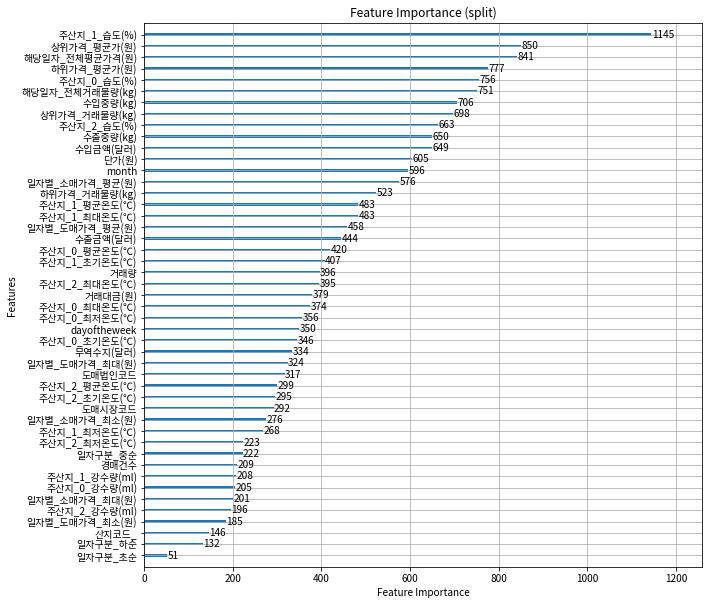

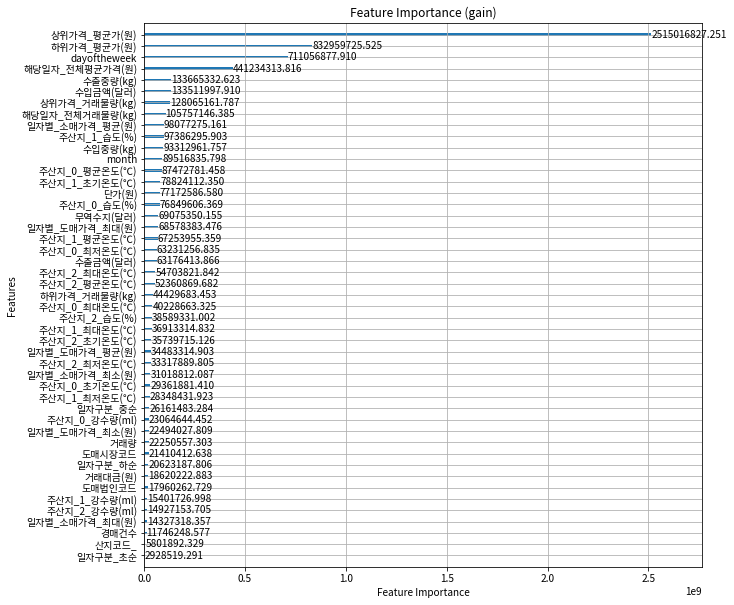

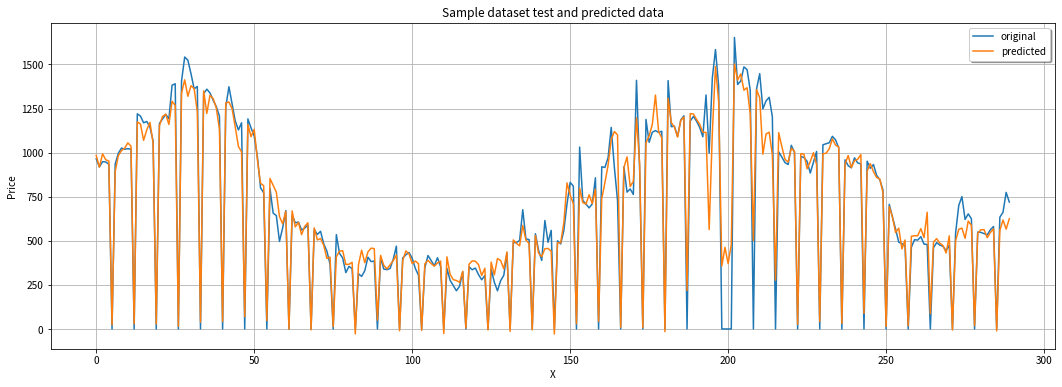

In [6]:
#### evaluation
# 0 ~ 36
NUM = 22

## model load
lgbm_model = lgb.Booster(model_file = f'model{now}/lgbm-{NUM}-1000-15.txt') # model_test

## data load
df = pd.read_csv(f'./data/train/train_{NUM}.csv')

for j in df.columns: 
	df[j] = df[j].replace({' ': np.nan})

# 사용할 열 선택 및 index 설정
# df.drop(tr_del_list, axis=1, inplace=True)

df['datetime'] = pd.to_datetime(df['datadate'], format='%Y%m%d')
df.drop('datadate', axis=1, inplace=True)

# df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['dayoftheweek'] = df['datetime'].dt.day_of_week

df.drop(cat_del, axis=1, inplace=True)

df.set_index('datetime', drop=True, inplace=True)

# df.set_index('datadate', drop=True, inplace=True)

# nan 처리
# df = df.fillna(0)

# to categorical type
# for NUM_i in range(1,3):
#     df[df.columns[NUM_i]] = df[df.columns[NUM_i]].astype('category')

for i_ca in enumerate(cat_features) :
	ca = i_ca[1]
	df[ca] = df[ca].astype("category")

# 변수와 타겟 분리
# x, y = df[[i for i in df.columns if i != '해당일자_전체평균가격(원)']], df['해당일자_전체평균가격(원)']
x, y = df, df['해당일자_전체평균가격(원)']

# type 변경
x = x.astype({'주산지_0_습도(%)':'float64', '주산지_1_습도(%)':'float64','주산지_2_습도(%)':'float64'})

# 14 or 21
y = y[14:]

# y의 길이와 같은 길이로 설정
xdata = x[:len(y)]
ydata = y

# train, validation 분리 (8 : 2)
x_train, x_val, y_train, y_val = train_test_split(xdata, ydata, test_size=0.2, shuffle=False, random_state=1215)


# SPLIT
ax = lgb.plot_importance(lgbm_model, max_num_features=-1, importance_type='split', figsize=(10,10))
ax.set(title=f'Feature Importance (split)',
	xlabel='Feature Importance',
	ylabel='Features')


# GAIN
ax = lgb.plot_importance(lgbm_model, max_num_features=-1, importance_type='gain', figsize=(10,10))
ax.set(title=f'Feature Importance (gain)',
	xlabel='Feature Importance',
	ylabel='Features')

# mse check
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

y_pred = lgbm_model.predict(x_val)
y_val = y_val.fillna(0)

mse_ = mean_squared_error(y_val, y_pred)
rmse_ = mse_**(0.5)
print("mse: %.2f" % mse_)
print("rmse: %.2f" % rmse_)

x_ax = range(len(y_val))
plt.figure(figsize=(18, 6))
plt.plot(x_ax, y_val, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Sample dataset test and predicted data")
plt.xlabel('X')
plt.ylabel('Price')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

&nbsp;

## Test 과정

In [30]:
col_del = [i for i in cat_del if i in df.columns]
df.drop(col_del, axis=1)

[]

In [7]:
# d-day
zero_csv = [0 for i in range(14)]  # 시점이 비어있는 데이터 0으로 채우기 위한 변수

for i in tqdm(range(10)):
    data_list = glob(f'./data/test/set_{i}/*.csv')

    for idx,j in enumerate(data_list):
        df = pd.read_csv(j)

        if len(df) == 0:
            df['zero_non'] = zero_csv
            df = df.fillna(0)
            df.drop('zero_non', axis=1, inplace=True)


        file_number = j.split('test_')[1].split('.')[0]

        # 사용할 열 선택, index 설정
        # df.drop(ts_del_list, axis=1, inplace=True)

        df['datetime'] = pd.to_datetime(df['datadate'], format='%Y%m%d', errors='ignore')
        df.drop('datadate', axis=1, inplace=True)

        try:
            # df['year'] = df['datetime'].dt.year
            df['month'] = df['datetime'].dt.month
            df['dayoftheweek'] = df['datetime'].dt.day_of_week
        except:
            # df['year'] = 2000
            df['month'] = 1
            df['dayoftheweek'] = 0

        df.set_index('datetime', drop=True, inplace=True)

        # df.set_index('datadate', drop=True, inplace=True)

        # train input 과 형상 맞추기
        col_del = [i for i in cat_del if i in df.columns]
        df.drop(col_del, axis=1, inplace=True)

        add_col = [i for i in check_col if i not in df.columns]

        for a in add_col:
            df[a] = 0

        # ' ' -> nan 으로 변경
        for a in df.columns:
            df[a] = df[a].replace({' ': np.nan})

        # nan 처리
        # df = df.fillna(0)

        # to categorical type
        # for NUM_i in range(1,3):
        #     df[df.columns[NUM_i]] = df[df.columns[NUM_i]].astype('category')

        for i_ca in enumerate(cat_features) :
            ca = i_ca[1]
            df[ca] = df[ca].astype("category")

        # model test
        if os.path.exists(f'./model_output_{epoch}_{batch}') == False:
            os.mkdir(f'./model_output_{epoch}_{batch}')

        if os.path.exists(f'./model_output_{epoch}_{batch}/set_{i}') == False:
            os.mkdir(f'./model_output_{epoch}_{batch}/set_{i}')

        # 해당하는 모델 불러오기
        lgbm_model = lgb.Booster(model_file = f'./model{now}/lgbm-{file_number}-{epoch}-{batch}.txt') # model_test
        pred = lgbm_model.predict(df)


        # 결과 저장
        save_df = pd.DataFrame(pred)
        save_df.to_csv(f'./model_output_{epoch}_{batch}/set_{i}/predict_{file_number}.csv', index=False)

100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


In [8]:
# 4w
zero_csv = [0 for i in range(14)]  # 시점이 비어있는 데이터 0으로 채우기 위한 변수

for i in tqdm(range(10)):
    data_list = glob(f'./data/test/set_{i}/*.csv')

    for idx,j in enumerate(data_list):
        df = pd.read_csv(j)

        if len(df) == 0:
            df['zero_non'] = zero_csv
            df = df.fillna(0)
            df.drop('zero_non', axis=1, inplace=True)


        file_number = j.split('test_')[1].split('.')[0]

        # 사용할 열 선택, index 설정
        # df.drop(ts_del_list, axis=1, inplace=True)

        df['datetime'] = pd.to_datetime(df['datadate'], format='%Y%m%d', errors='ignore')
        df.drop('datadate', axis=1, inplace=True)

        try:
            # df['year'] = df['datetime'].dt.year
            df['month'] = df['datetime'].dt.month
            df['dayoftheweek'] = df['datetime'].dt.day_of_week
        except:
            # df['year'] = 2000
            df['month'] = 1
            df['dayoftheweek'] = 0

        df.set_index('datetime', drop=True, inplace=True)

        # df.set_index('datadate', drop=True, inplace=True)

        # train input 과 형상 맞추기
        col_del = [i for i in cat_del if i in df.columns]
        df.drop(col_del, axis=1, inplace=True)
        
        add_col = [i for i in check_col if i not in df.columns]

        for a in add_col:
            df[a] = 0

        # ' ' -> nan 으로 변경
        for a in df.columns:
            df[a] = df[a].replace({' ': np.nan})

        # nan 처리
        # df = df.fillna(0)

        # to categorical type
        # for NUM_i in range(1,3):
        #     df[df.columns[NUM_i]] = df[df.columns[NUM_i]].astype('category')

        for i_ca in enumerate(cat_features) :
            ca = i_ca[1]
            df[ca] = df[ca].astype("category")

        # model test
        if os.path.exists(f'./model_output_4w_{epoch}_{batch}') == False:
            os.mkdir(f'./model_output_4w_{epoch}_{batch}')

        if os.path.exists(f'./model_output_4w_{epoch}_{batch}/set_{i}') == False:
            os.mkdir(f'./model_output_4w_{epoch}_{batch}/set_{i}')

        # 해당하는 모델 불러오기
        lgbm_model = lgb.Booster(model_file = f'./model{now}/lgbm_4w-{file_number}-{epoch}-{batch}.txt') # model_test
        pred = lgbm_model.predict(df)


        # 결과 저장
        save_df = pd.DataFrame(pred)
        save_df.to_csv(f'./model_output_4w_{epoch}_{batch}/set_{i}/predict_{file_number}.csv', index=False)

100%|██████████| 10/10 [00:13<00:00,  1.33s/it]


In [9]:
file_number

'29'

&nbsp;

## 정답 제출 파일생성

In [10]:
# d-day
for k in tqdm(range(10)):

  globals()[f'set_df_{k}'] = pd.DataFrame()
  answer_df_list = glob(f'./model_output_{epoch}_{batch}/set_{k}/*.csv') # 예측한 결과 불러오기
  # answer_df_list_4w = glob(f'./model_output_4w_{epoch}_{batch}/set_{k}/*.csv') # 예측한 결과 불러오기 4w
  pum_list = glob(f'./aT_test_raw/sep_{k}/*.csv') # 기존 test input 불러오기
  pummok = [a for a in pum_list if 'pummok' in a.split('/')[-1]]

  for i in answer_df_list:
    df = pd.read_csv(i)
    number = i.split('_')[-1].split('.')[0]

    base_number = 0
    for p in pummok:
      if number == p.split('_')[-1].split('.')[0]:
        pum_df = pd.read_csv(p)

        if len(pum_df) != 0:
           base_number = pum_df.iloc[len(pum_df)-1]['해당일자_전체평균가격(원)']  # 기존 각 sep 마다 test input의 마지막 target 값 가져오기 (변동률 계산을 위해)
        else:
          base_number = np.nan
    
    globals()[f'set_df_{k}'][f'품목{number}']  = [base_number] + list(df[df.columns[-1]].values) # 각 품목당 순서를 t, t+1 ... t+28 로 변경

  globals()[f'set_df_{k}'] = globals()[f'set_df_{k}'][[f'품목{col}' for col in range(37)]] # 열 순서를 품목0 ~ 품목36 으로 변경

100%|██████████| 10/10 [00:01<00:00,  5.82it/s]


In [11]:
# 4w
for k in tqdm(range(10)):

  globals()[f'set_df_4w_{k}'] = pd.DataFrame()
#   answer_df_list = glob(f'./model_output_{epoch}_{batch}/set_{k}/*.csv') # 예측한 결과 불러오기
  answer_df_list_4w = glob(f'./model_output_4w_{epoch}_{batch}/set_{k}/*.csv') # 예측한 결과 불러오기 4w
  pum_list = glob(f'./aT_test_raw/sep_{k}/*.csv') # 기존 test input 불러오기
  pummok = [a for a in pum_list if 'pummok' in a.split('/')[-1]]

  for i in answer_df_list_4w:
    df_4w = pd.read_csv(i)
    number_4w = i.split('_')[-1].split('.')[0]

    base_number_4w = 0
    for p in pummok:
      if number_4w == p.split('_')[-1].split('.')[0]:
        pum_df_4w = pd.read_csv(p)

        if len(pum_df_4w) != 0:
           base_number_4w = pum_df_4w.iloc[len(pum_df_4w)-1]['해당일자_전체평균가격(원)']  # 기존 각 sep 마다 test input의 마지막 target 값 가져오기 (변동률 계산을 위해)
        else:
          base_number_4w = np.nan
    
    globals()[f'set_df_4w_{k}'][f'품목{number_4w}']  = [base_number_4w] + list(df_4w[df_4w.columns[-1]].values) # 각 품목당 순서를 t, t+1 ... t+28 로 변경

  globals()[f'set_df_4w_{k}'] = globals()[f'set_df_4w_{k}'][[f'품목{col}' for col in range(37)]] # 열 순서를 품목0 ~ 품목36 으로 변경

100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


- 변동률 계산을 위한 t, t+1 ... t+28 설정

In [12]:
set_df_0

,품목0,품목1,품목2,품목3,품목4,품목5,품목6,품목7,품목8,품목9,품목10,품목11,품목12,품목13,품목14,품목15,품목16,품목17,품목18,품목19,품목20,품목21,품목22,품목23,품목24,품목25,품목26,품목27,품목28,품목29,품목30,품목31,품목32,품목33,품목34,품목35,품목36
0,3871.125000,1362.117613,2909.783785,3400.075583,3947.809169,9253.947514,2717.280000,3361.030923,4911.899864,1173.018633,1337.034820,2053.354945,3003.205509,3148.414256,6573.839289,1089.126835,3838.815254,2254.390206,12538.931552,2990.863631,2965.711352,505.929304,937.367871,4147.240906,1231.113220,3323.910031,3056.787271,8640.811309,602.005658,1105.412623,1566.274239,3633.464557,5454.710444,5619.188362,5230.620027,2905.100888,2087.675036
1,3256.689678,1101.362823,1546.446684,1946.399827,1382.450880,4567.200895,2272.413206,1051.594501,3542.970916,1403.689289,1599.775003,1986.371386,3693.207359,2615.269584,7343.838472,2442.824529,3749.706059,2422.665901,8698.033308,1801.023991,946.161807,551.594815,572.991169,2454.868131,883.088026,1762.703635,2594.306570,4073.528305,631.761412,963.026696,707.899065,1960.514707,4402.255309,3897.230167,4130.123539,1894.791472,1033.016773
2,2676.578655,1643.686484,2560.661857,2154.273108,3146.460093,5433.898549,3863.625217,2359.590813,3634.839802,1212.925032,1431.118142,2123.616489,2191.688716,2494.866975,6456.512967,1905.109784,4867.611361,1749.204209,9458.008967,1947.173670,1478.190883,258.585026,821.696775,2662.520766,521.807840,918.511042,2460.911767,4625.230659,339.970972,740.424105,639.716875,3028.180357,4676.943113,3412.620507,4346.013577,1627.656624,992.502034
3,2792.709331,1260.689369,1699.990457,2484.070396,1902.404226,4980.714451,6506.150533,2022.188490,2916.367180,1458.274318,1569.012698,2175.073533,3242.278361,2700.229174,6712.495031,2811.688778,5581.487244,2743.430099,9534.312945,3000.568890,1914.218984,531.996304,676.511932,2670.684377,919.660903,1711.351091,3147.923582,8178.171616,702.841054,959.886000,659.278824,3122.119914,3610.677335,4672.127996,4905.241785,2731.488210,1089.553247
4,3147.593208,956.082922,1955.362142,3277.488524,3353.757566,6544.818974,2747.890987,2406.087257,3737.885300,1012.542990,1199.889899,1951.209191,2623.151959,2375.949776,5909.310622,894.201255,2709.713648,2511.614198,8138.108899,2799.592056,1835.971447,648.343409,682.023629,1908.451629,800.614376,1744.792453,3171.201785,4606.081995,477.855606,1020.725746,990.835319,3007.224569,4300.487108,5815.367906,4351.777578,1560.641361,1681.803809
5,3773.326993,1368.123687,2260.263132,2831.254747,3176.986550,7107.726228,2728.462554,2541.593529,3649.730664,1507.100701,1217.293799,1937.928356,2279.829301,2280.950783,6159.551704,1025.513073,3764.217356,2372.976569,8194.012472,2031.246940,1608.454135,437.805120,851.900979,3983.446153,926.859487,1737.609682,2627.752277,4574.551919,532.385299,761.236932,1068.908066,2740.171695,5374.560985,5909.984253,4789.709951,2398.050080,1206.806183
6,4071.286317,1326.922074,2542.933453,3047.713541,3393.128976,6630.109065,4072.498472,2225.171292,3950.920755,1549.781770,1444.718979,1938.374572,2836.228802,2389.962377,6477.551113,1242.694241,3502.317176,1935.277277,8181.875584,2186.311987,1760.101444,507.741497,886.899470,3778.086248,903.535312,1720.404707,2564.012474,5871.636876,493.755966,897.695303,952.899848,3204.113404,3811.821363,6755.432882,4550.370177,2185.950543,1211.627406
7,6604.200918,1338.437998,2649.889763,3045.053702,3580.097583,6387.946731,2753.484156,1718.522313,4184.639888,1191.617532,1484.596006,1978.616666,2828.096083,2434.895405,6420.800147,1162.589113,3965.587173,1605.348624,8572.906166,1578.154285,1518.566395,500.178018,846.675607,3490.795485,1133.866804,1875.488085,3449.793500,4320.225818,476.350481,1025.367684,999.154765,2586.954248,5026.422489,6380.233343,4086.504966,2164.626325,1164.690866
8,4096.330961,1524.402017,2344.971216,3046.978394,3564.187541,7169.254408,3080.175870,1703.464005,3903.244904,1522.974919,1426.393444,1941.728471,2718.753604,2320.082400,7908.922334,1903.790333,3719.507985,1467.626789,8616.482965,2287.779169,2124.454734,471.882629,952.054251,3148.063495,803.031557,21

In [13]:
set_df_4w_0

,품목0,품목1,품목2,품목3,품목4,품목5,품목6,품목7,품목8,품목9,품목10,품목11,품목12,품목13,품목14,품목15,품목16,품목17,품목18,품목19,품목20,품목21,품목22,품목23,품목24,품목25,품목26,품목27,품목28,품목29,품목30,품목31,품목32,품목33,품목34,품목35,품목36
0,3871.125000,1362.117613,2909.783785,3400.075583,3947.809169,9253.947514,2717.280000,3361.030923,4911.899864,1173.018633,1337.034820,2053.354945,3003.205509,3148.414256,6573.839289,1089.126835,3838.815254,2254.390206,12538.931552,2990.863631,2965.711352,505.929304,937.367871,4147.240906,1231.113220,3323.910031,3056.787271,8640.811309,602.005658,1105.412623,1566.274239,3633.464557,5454.710444,5619.188362,5230.620027,2905.100888,2087.675036
1,3322.519715,1044.932107,1784.979317,2231.486391,1750.539432,4451.375334,3700.336949,582.791221,3397.918860,1400.006401,1488.898870,2346.108872,3146.222843,2466.923639,7087.557495,2606.811794,4684.976604,2430.799557,10929.145853,2137.210710,1140.499033,534.684684,630.244753,2477.642793,905.076183,1823.417777,2287.584272,4747.333875,372.850320,1001.109821,775.039727,3501.263463,3760.849198,4827.986385,3576.902603,1773.927936,1084.302674
2,2484.307889,1520.753173,2398.675409,2254.158365,3041.924588,6702.709047,9050.130287,1921.403246,3505.171220,970.551426,1330.105160,2228.806902,2454.325575,2450.732345,6605.479305,1828.286591,3675.684259,1814.978889,9954.696724,1778.233299,1552.013135,353.873346,802.913396,2263.299108,756.649831,801.729397,2689.751838,4443.587944,335.592314,840.891826,677.803910,3234.653024,4489.991997,3127.803056,3757.451124,1993.097354,1245.233405
3,2476.882334,1188.174879,1851.264771,2284.063551,1672.151336,4869.286632,9503.813444,1775.404673,2863.580483,1480.973806,1469.873625,2118.922371,2906.503712,2614.596389,5956.317682,2778.008839,4393.773630,2799.696464,7751.313068,2947.920664,1890.144986,607.263898,542.802107,1774.407786,816.897051,1618.206538,3727.127342,6241.093074,473.219242,985.161649,733.763914,4009.397802,3385.054691,5197.788826,4570.994201,2494.149896,1276.183603
4,3110.858047,1125.068790,2802.603156,2819.321738,2875.371864,6899.442726,3904.617529,2555.793790,3681.637640,1495.397568,1386.185911,2488.023123,2688.277676,2551.101630,6723.815370,1826.356630,3883.188993,2635.601287,7477.351695,2626.661654,2167.445070,463.498966,753.188298,2429.846069,888.430685,1740.044752,3153.560668,6046.136874,600.575098,1072.730163,1062.331554,4138.720315,4818.859027,5289.592256,4994.063266,1966.045682,1344.031988
5,3239.322972,1366.745804,2678.586148,2495.783380,2900.371995,6709.761993,3875.682256,2350.888626,3595.707340,1502.192530,1256.174001,2379.640444,2655.458338,2939.956040,6366.963137,2024.361166,4870.931314,2619.584703,7282.639416,1989.817525,1651.273526,444.889428,699.349901,3337.964058,1009.645295,1686.158000,2788.523308,5418.597756,632.597314,944.397804,1096.446905,2838.977694,4924.425493,5868.787332,4377.611637,2239.550485,1380.783725
6,3148.226462,1415.606855,2927.630634,2727.055001,3077.999985,6622.045567,3489.740311,1458.895557,4501.006722,1484.072611,1521.608361,2341.376561,2646.529929,2726.358019,7181.672146,2271.023880,4089.342745,2661.378013,7437.792604,1592.020313,1451.572232,413.821398,822.667862,2917.168810,779.507625,1655.774449,2532.953558,4525.259375,550.952647,1003.349916,1027.514622,2515.991058,4225.817967,6805.439580,3534.618865,2071.437473,1045.706868
7,5626.335342,1380.214736,2769.181939,2733.074125,3230.530750,6346.621587,3867.216318,1414.854707,4244.470289,1405.760437,1437.997529,2336.057982,3147.825571,2290.824443,6753.061921,2339.676406,4027.943609,2385.454024,8392.967344,2094.795026,1452.745226,434.383692,834.504251,2599.238114,1000.482275,1693.031531,2683.651573,5528.219362,581.644945,1096.123842,1040.889936,2623.692873,3810.204690,6907.655555,3287.994030,2011.372817,1011.410331
8,3616.205482,1502.646039,2328.517256,2893.276246,3223.105935,6582.874592,3471.340708,1447.548860,3755.588881,1247.019590,1470.414427,2166.380555,2632.229204,2342.253131,7746.480794,2240.405055,4007.656344,2077.572942,7784.830633,1842.471164,1565.164222,484.427823,781.405665,2695.977516,990.

- 변동률 계산 

In [14]:
date = [f'd+{i}' for i in range(1,15)] + ['d+22 ~ 28 평균']


for k in range(10):
  globals()[f'answer_df_{k}'] = pd.DataFrame()
  for c in globals()[f'set_df_{k}'].columns:
    base_d = globals()[f'set_df_{k}'][c][0] # 변동률 기준 t 값

    ans_1_14 = []
    for i in range(14):
      ans_1_14.append((globals()[f'set_df_{k}'][c].iloc[i+1]- base_d)/base_d)  # t+1 ~ t+14 까지는 (t+n - t)/t 로 계산

    ans_22_28 = ((globals()[f'set_df_4w_{k}'][c][8:10].sum() + globals()[f'set_df_4w_{k}'][c][11:15].sum())/6 - base_d)/base_d # 4w -> 8 ~ 14 (except: 10)
    # ans_22_28 = ((globals()[f'set_df_4w_{k}'][c][1:3].sum() + globals()[f'set_df_4w_{k}'][c][4:8].sum())/6 - base_d)/base_d # 4w -> 1 ~ 7 (except: 3)
    # ans_22_28 = (globals()[f'set_df_4w_{k}'][c][8:15].mean() - base_d)/base_d # t+22 ~ t+28은 np.mean(t+22 ~ t+28) - t / t

    globals()[f'answer_df_{k}'][f'{c} 변동률'] = ans_1_14 + [ans_22_28]
  
  globals()[f'answer_df_{k}']['Set'] = k # set 번호 설정
  globals()[f'answer_df_{k}']['일자'] = date # 일자 설정

- sep 0  ~ sep 9 까지 합치기

In [15]:
# 위에서 계산된 변동률 들을 합쳐주는 과정

all_df =pd.DataFrame()
for i in range(10):
  if i== 0 :
    all_df = pd.concat([all_df, globals()[f'answer_df_{i}']],axis=1)
  else:
    all_df = pd.concat([all_df, globals()[f'answer_df_{i}']])


all_df = all_df[['Set','일자'] + list(all_df.columns[:-2])]
all_df.reset_index(drop=True, inplace=True)

- 정답 양식으로 변경

In [16]:
# set, 일자 기억하기위해 따로 저장

re_set = list(all_df['Set'])
re_date = list(all_df['일자'])


# 정답 양식 불러오기
out_ans = pd.read_csv('./answer_example.csv')

# 두 dataframe 합치기 (nan + 숫자 = nan 이용)
submit_df = all_df + out_ans

submit_df['Set'] = re_set
submit_df['일자'] = re_date

# 최종 저장
submit_df.to_csv(f'./submit_{now}.csv',index=False)
print(f'submit_{now}')

submit_09271553


- 계산된 변동률 결과물

In [17]:
all_df

,Set,일자,품목0 변동률,품목1 변동률,품목2 변동률,품목3 변동률,품목4 변동률,품목5 변동률,품목6 변동률,품목7 변동률,품목8 변동률,품목9 변동률,품목10 변동률,품목11 변동률,품목12 변동률,품목13 변동률,품목14 변동률,품목15 변동률,품목16 변동률,품목17 변동률,품목18 변동률,품목19 변동률,품목20 변동률,품목21 변동률,품목22 변동률,품목23 변동률,품목24 변동률,품목25 변동률,품목26 변동률,품목27 변동률,품목28 변동률,품목29 변동률,품목30 변동률,품목31 변동률,품목32 변동률,품목33 변동률,품목34 변동률,품목35 변동률,품목36 변동률
0,0,d+1,-0.158723,-0.191433,-0.468536,-0.427542,-0.649818,-0.506459,-0.163718,-0.687121,-0.278696,0.196647,0.196510,-0.032622,0.229755,-0.169338,0.117131,1.242920,-0.023213,0.074644,-0.306318,-0.397825,-0.680966,0.090261,-0.388723,-0.408072,-0.282691,-0.469690,-0.151296,-0.528571,0.049428,-0.128808,-0.548036,-0.460428,-0.192944,-0.306443,-0.210395,-0.347771,-0.505183
1,0,d+2,-0.308579,0.206714,-0.119982,-0.366404,-0.202986,-0.412802,0.421872,-0.297956,-0.259993,0.034020,0.070367,0.034218,-0.270217,-0.207580,-0.017847,0.749208,0.267998,-0.224090,-0.245709,-0.348959,-0.501573,-0.488891,-0.123400,-0.358002,-0.576150,-0.723665,-0.194935,-0.464723,-0.435269,-0.330183,-0.591568,-0.166586,-0.142586,-0.392684,-0.169121,-0.439725,-0.524590
2,0,d+3,-0.278579,-0.074464,-0.415767,-0.269407,-0.518111,-0.461774,1.394361,-0.398343,-0.406265,0.243181,0.173502,0.059278,0.079606,-0.142353,0.021092,1.581599,0.453961,0.216928,-0.239623,0.003245,-0.354550,0.051523,-0.278286,-0.356033,-0.252984,-0.485139,0.029814,-0.053541,0.167499,-0.131649,-0.579078,-0.140732,-0.338063,-0.168540,-0.062206,-0.059761,-0.478102
3,0,d+4,-0.186905,-0.298091,-0.328004,-0.036054,-0.150476,-0.292754,0.011265,-0.284122,-0.239014,-0.136806,-0.102574,-0.049746,-0.126549,-0.245350,-0.101087,-0.178974,-0.294128,0.114099,-0.350973,-0.063952,-0.380934,0.281490,-0.272406,-0.539826,-0.349683,-0.475078,0.037430,-0.466939,-0.206227,-0.076611,-0.367393,-0.172353,-0.211601,0.034912,-0.168019,-0.462793,-0.194413
4,0,d+5,-0.025263,0.004409,-0.223220,-0.167297,-0.195253,-0.231925,0.004115,-0.243805,-0.256962,0.284805,-0.089557,-0.056214,-0.240868,-0.275524,-0.063021,-0.058408,-0.019433,0.052602,-0.346514,-0.320849,-0.457650,-0.134652,-0.091178,-0.039495,-0.247137,-0.477239,-0.140355,-0.470588,-0.115647,-0.311355,-0.317547,-0.245852,-0.014694,0.051751,-0.084294,-0.174538,-0.421938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,9,d+11,-0.252329,-0.202302,-0.021563,0.109811,0.049668,0.038534,-0.381070,NaN,-0.171651,-0.103046,-0.127103,-0.183896,0.091238,-0.121673,0.059773,-0.096172,0.208186,0.244826,-0.211652,-0.079816,-0.107370,-0.271992,0.093177,-0.149083,-0.013137,-0.330325,0.605015,-0.193379,-0.078455,-0.050898,-0.206540,-0.197984,-0.190668,-0.030063,0.207604,-0.061878,-0.248148
146,9,d+12,-0.275571,-0.157317,-0.008974,-0.061769,0.089409,0.049233,-0.035831,NaN,-0.153326,-0.103682,-0.193593,-0.150520,-0.026798,-0.177314,0.018300,-0.143838,0.311181,0.072035,-0.323496,-0.134537,-0.015950,-0.177256,-0.299723,-0.077979,-0.132671,-0.263709,0.463699,-0.253428,-0.120981,-0.090625,-0.138524,-0.166270,-0.201495,-0.065476,0.250937,-0.108086,-0.304484
147,9,d+13,-0.343452,-0.034105,-0.043241,-0.016983,-0.000900,0.127940,-0.264010,NaN,-0.205763,-0.087490,-0.150261,-0.107518,0.030410,-0.203336,0.112971,-0.100494,-0.119636,0.160646,0.037207,-0.148994,-0.128810,-0.023389,-0.308622,0.056651,-0.198715,-0.329014,-0.135695,-0.266751,-0.197459,-0.158006,-0.076919,-0.276077,-0.059094,-0.075480,0.003704,-0.213467,-0.310378
148,9,d+14,-0.288577,-0.062052,0.032305,-0.067640,0.079918,0.134266,-0.449796,NaN,-0.179083,-0.119862,-0.188869,-0.097700,-0.077932,-0.164751,-0.043476,-0.136691,-0.277149,0.438468,0.095739,-0.132003,-0.124415,-0.029071,-0.195554,-0.097305,-0.117532,-0.199784,-0.135168,-0.171669,-0.224467,-0.110596,-0.180485,-0.185727,-0.057452,0.282966,0.102348,-0.168477,-0.319559


- 제출 양식

In [18]:
out_ans

,Set,일자,품목0 변동률,품목1 변동률,품목2 변동률,품목3 변동률,품목4 변동률,품목5 변동률,품목6 변동률,품목7 변동률,품목8 변동률,품목9 변동률,품목10 변동률,품목11 변동률,품목12 변동률,품목13 변동률,품목14 변동률,품목15 변동률,품목16 변동률,품목17 변동률,품목18 변동률,품목19 변동률,품목20 변동률,품목21 변동률,품목22 변동률,품목23 변동률,품목24 변동률,품목25 변동률,품목26 변동률,품목27 변동률,품목28 변동률,품목29 변동률,품목30 변동률,품목31 변동률,품목32 변동률,품목33 변동률,품목34 변동률,품목35 변동률,품목36 변동률
0,0,d+1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,d+2,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,d+3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,d+4,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,d+5,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,9,d+11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146,9,d+12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147,9,d+13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148,9,d+14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- 제출 양식 반영한 최종 결과물 (**실 제출용**)

In [19]:
submit_df

,Set,일자,품목0 변동률,품목1 변동률,품목2 변동률,품목3 변동률,품목4 변동률,품목5 변동률,품목6 변동률,품목7 변동률,품목8 변동률,품목9 변동률,품목10 변동률,품목11 변동률,품목12 변동률,품목13 변동률,품목14 변동률,품목15 변동률,품목16 변동률,품목17 변동률,품목18 변동률,품목19 변동률,품목20 변동률,품목21 변동률,품목22 변동률,품목23 변동률,품목24 변동률,품목25 변동률,품목26 변동률,품목27 변동률,품목28 변동률,품목29 변동률,품목30 변동률,품목31 변동률,품목32 변동률,품목33 변동률,품목34 변동률,품목35 변동률,품목36 변동률
0,0,d+1,-0.158723,-0.191433,-0.468536,-0.427542,-0.649818,-0.506459,-0.163718,-0.687121,-0.278696,0.196647,0.196510,-0.032622,0.229755,-0.169338,0.117131,1.242920,NaN,0.074644,-0.306318,-0.397825,-0.680966,0.090261,-0.388723,-0.408072,-0.282691,-0.469690,-0.151296,-0.528571,0.049428,-0.128808,-0.548036,-0.460428,-0.192944,-0.306443,-0.210395,-0.347771,-0.505183
1,0,d+2,-0.308579,0.206714,-0.119982,-0.366404,-0.202986,-0.412802,NaN,-0.297956,-0.259993,0.034020,0.070367,0.034218,-0.270217,-0.207580,-0.017847,0.749208,0.267998,-0.224090,-0.245709,-0.348959,-0.501573,-0.488891,-0.123400,-0.358002,-0.576150,-0.723665,-0.194935,-0.464723,-0.435269,-0.330183,-0.591568,-0.166586,-0.142586,-0.392684,-0.169121,-0.439725,-0.524590
2,0,d+3,NaN,NaN,NaN,NaN,NaN,NaN,1.394361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,d+4,-0.186905,-0.298091,-0.328004,-0.036054,-0.150476,-0.292754,NaN,-0.284122,-0.239014,-0.136806,-0.102574,-0.049746,-0.126549,-0.245350,-0.101087,-0.178974,-0.294128,0.114099,-0.350973,-0.063952,-0.380934,0.281490,-0.272406,-0.539826,-0.349683,-0.475078,0.037430,-0.466939,-0.206227,-0.076611,-0.367393,-0.172353,-0.211601,0.034912,-0.168019,-0.462793,-0.194413
4,0,d+5,-0.025263,0.004409,-0.223220,-0.167297,-0.195253,-0.231925,NaN,-0.243805,-0.256962,0.284805,-0.089557,-0.056214,-0.240868,-0.275524,-0.063021,-0.058408,-0.019433,0.052602,-0.346514,-0.320849,-0.457650,-0.134652,-0.091178,-0.039495,-0.247137,-0.477239,-0.140355,-0.470588,-0.115647,-0.311355,-0.317547,-0.245852,-0.014694,0.051751,-0.084294,-0.174538,-0.421938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,9,d+11,-0.252329,-0.202302,-0.021563,0.109811,0.049668,0.038534,-0.381070,NaN,-0.171651,-0.103046,-0.127103,-0.183896,0.091238,-0.121673,0.059773,-0.096172,0.208186,0.244826,-0.211652,-0.079816,-0.107370,-0.271992,0.093177,-0.149083,-0.013137,-0.330325,0.605015,-0.193379,-0.078455,-0.050898,-0.206540,-0.197984,-0.190668,-0.030063,0.207604,-0.061878,-0.248148
146,9,d+12,-0.275571,-0.157317,-0.008974,-0.061769,0.089409,0.049233,-0.035831,NaN,-0.153326,-0.103682,-0.193593,-0.150520,-0.026798,-0.177314,0.018300,-0.143838,0.311181,0.072035,-0.323496,-0.134537,-0.015950,-0.177256,-0.299723,-0.077979,-0.132671,-0.263709,0.463699,-0.253428,-0.120981,-0.090625,-0.138524,-0.166270,-0.201495,-0.065476,0.250937,-0.108086,-0.304484
147,9,d+13,-0.343452,-0.034105,-0.043241,-0.016983,-0.000900,0.127940,-0.264010,NaN,-0.205763,-0.087490,-0.150261,-0.107518,0.030410,-0.203336,0.112971,-0.100494,-0.119636,0.160646,0.037207,-0.148994,-0.128810,-0.023389,-0.308622,0.056651,-0.198715,-0.329014,-0.135695,-0.266751,-0.197459,-0.158006,-0.076919,-0.276077,-0.059094,-0.075480,0.003704,-0.213467,-0.310378
148,9,d+14,-0.288577,-0.062052,0.032305,-0.067640,0.079918,0.134266,-0.449796,NaN,-0.179083,-0.119862,-0.188869,-0.097700,-0.077932,-0.164751,-0.043476,-0.136691,-0.277149,0.438468,0.095739,-0.132003,-0.124415,-0.029071,-0.195554,-0.097305,-0.117532,-0.199784,-0.135168,-0.171669,-0.224467,-0.110596,-0.180485,-0.185727,-0.057452,0.282966,0.102348,-0.168477,-0.319559
